Diseñando un filtro FIR con aproximadamente 800 taps.
Advertencia: Longitud del filtro ajustada a 801 para que sea impar.
Longitud de la FFT aumentada a 4000 puntos para alta resolución frecuencial.


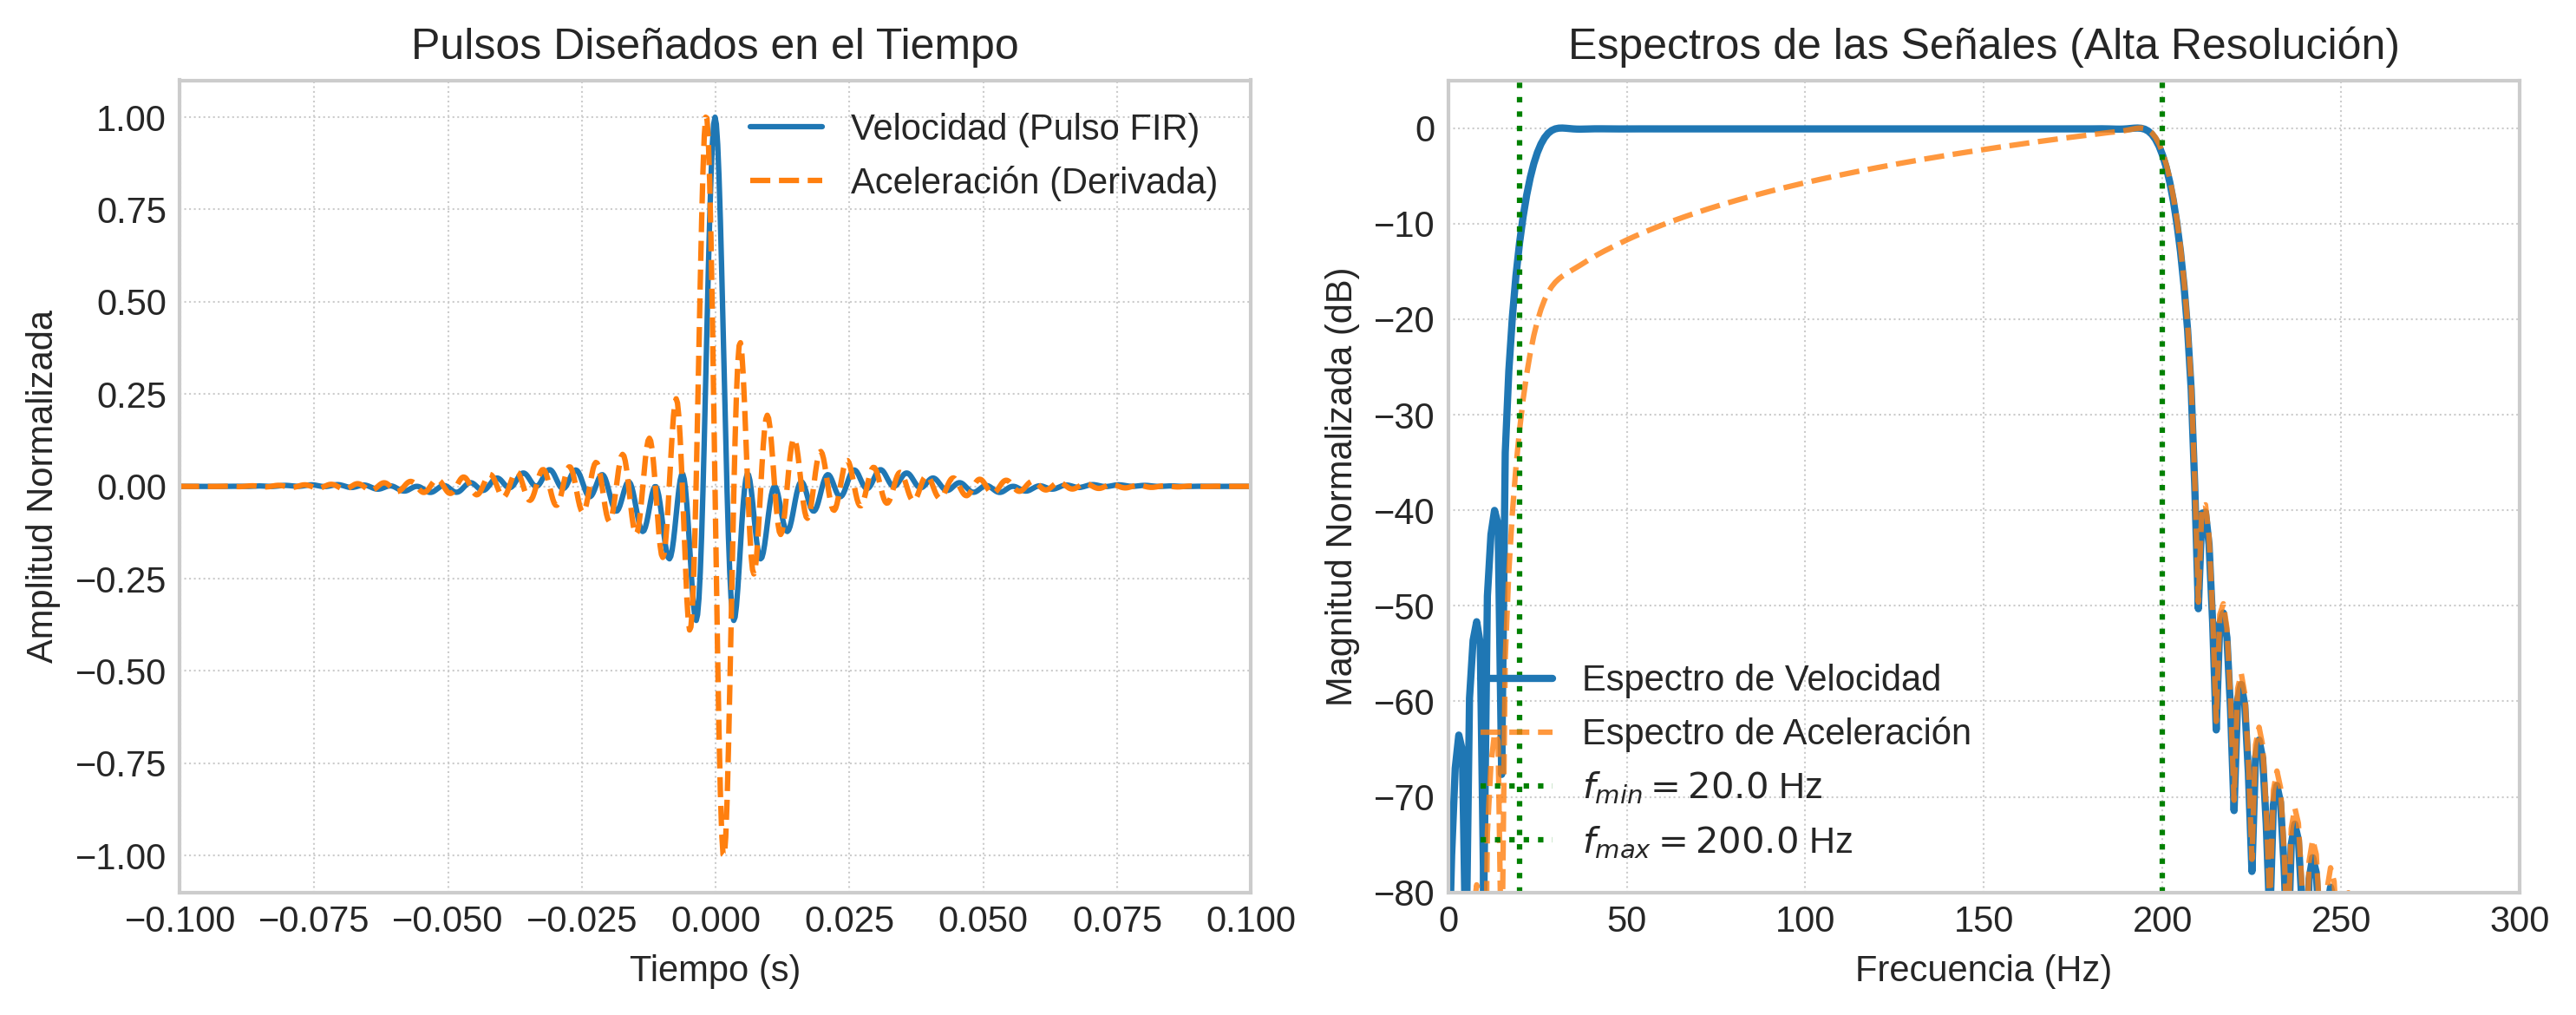

In [ ]:
import numpy as np
import scipy.fft as fft
from scipy.signal import windows
from matplotlib import pyplot as plt

# --- 1. FUNCIÓN DE DISEÑO DEL PULSO FIR (MODIFICADA) ---

def diseñar_pulso_velocidad_fir(num_taps, f_min, f_max, fs):
    """
    Diseña un pulso de velocidad de fase lineal (FIR) y devuelve tanto
    el pulso como la longitud final utilizada (ajustada a impar).

    Args:
        num_taps (int): Longitud deseada del filtro (número de puntos).
        f_min (float): Frecuencia de inicio de la banda de paso.
        f_max (float): Frecuencia de fin de la banda de paso.
        fs (float): Frecuencia de muestreo.

    Returns:
        tuple[np.ndarray, int]: Una tupla conteniendo:
            - El pulso de velocidad en el dominio del tiempo.
            - La longitud real del filtro (num_taps), ajustada a un número impar.
    """
    if num_taps % 2 == 0:
        num_taps += 1 # Asegurar que la longitud sea impar para un centro bien definido
        print(f"Advertencia: Longitud del filtro ajustada a {num_taps} para que sea impar.")

    # a. Crear el espectro de frecuencia ideal ("filtro de ladrillo")
    freqs = fft.rfftfreq(num_taps, 1/fs)
    ideal_response = np.zeros_like(freqs)
    pass_band_mask = (freqs >= f_min) & (freqs <= f_max)
    ideal_response[pass_band_mask] = 1.0

    # b. Anti-transformar para obtener la respuesta al impulso ideal (función sinc)
    impulse_response_ideal = fft.irfft(ideal_response, n=num_taps)

    # c. Crear una ventana para suavizar y truncar la sinc
    window = windows.hann(num_taps)

    # d. Aplicar la ventana, centrando primero el pico de la sinc
    fir_pulse = np.fft.fftshift(impulse_response_ideal) * window

    # --- Devolver el pulso Y la longitud final utilizada ---
    return fir_pulse, num_taps


# --- 2. FUNCIÓN PARA DERIVAR EL PULSO ---

def derivar_pulso(pulso, dt):
    """
    Calcula la derivada de un pulso de tiempo usando diferencias finitas.
    """
    return np.gradient(pulso, dt)


# --- BLOQUE PRINCIPAL DE EJECUCIÓN ---

if __name__ == "__main__":

    # --- 1. PARÁMETROS DE DISEÑO ---
    f_min = 20.0
    f_max = 200.0
    fs = 4000.0
    dt = 1.0 / fs

    # Elegir la longitud del filtro basándose en una banda de transición deseada
    transition_width = 20.0  # Hz
    num_taps_deseado = int((4 * fs) / transition_width) # Regla práctica para ventana de Hann
    print(f"Diseñando un filtro FIR con aproximadamente {num_taps_deseado} taps.")

    # --- 2. DISEÑO Y GENERACIÓN DE SEÑALES ---
    # Capturar tanto el pulso como su longitud real y final
    velo_t_corto, num_taps_real = diseñar_pulso_velocidad_fir(num_taps_deseado, f_min, f_max, fs)
    
    accel_t_corto = derivar_pulso(velo_t_corto, dt)
    
    # Crear un vector de tiempo que coincida con la longitud REAL del pulso
   # Línea corregida y más segura
    t_start = -num_taps_real//2 * dt
    t_stop = num_taps_real//2 * dt
    t_corto = np.linspace(t_start, t_stop, num_taps_real)

    # --- 3. CÁLCULO DE RESPUESTAS EN FRECUENCIA (CON ZERO-PADDING) ---
    # a. Definir la longitud total de la señal para la FFT (alta resolución)
    T_final_fft = (1 / f_min) * 20
    N_fft = int(T_final_fft * fs)
    print(f"Longitud de la FFT aumentada a {N_fft} puntos para alta resolución frecuencial.")

    # b. Crear señales largas con relleno de ceros
    velo_t_largo = np.zeros(N_fft)
    accel_t_largo = np.zeros(N_fft)
    
    # c. Copiar los pulsos cortos en el centro de las señales largas, usando la longitud real
    offset = (N_fft - num_taps_real) // 2
    velo_t_largo[offset : offset + num_taps_real] = velo_t_corto
    accel_t_largo[offset : offset + num_taps_real] = accel_t_corto
    
    # d. Calcular la FFT sobre las señales LARGAS
    V_f = fft.rfft(velo_t_largo)
    A_f = fft.rfft(accel_t_largo)
    freqs = fft.rfftfreq(N_fft, dt)

    # Normalizar para la visualización
    mag_db_V = 20 * np.log10(np.abs(V_f) + 1e-12)
    mag_db_V_norm = mag_db_V - np.max(mag_db_V)
    mag_db_A = 20 * np.log10(np.abs(A_f) + 1e-12)
    mag_db_A_norm = mag_db_A - np.max(mag_db_A)

   # --- 4. CREACIÓN DE LOS GRÁFICOS (VERSIÓN FINAL) ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=300)

# --- Gráfico de la Izquierda: Dominio del Tiempo (mostrando el retardo) ---
ax1.set_title('Pulsos Diseñados en el Tiempo (Retardado)')

# Crear el vector de tiempo para la señal LARGA
t_largo = np.arange(N_fft) * dt

# Graficar las señales LARGAS (que contienen el pulso y los ceros)
ax1.plot(t_largo, velo_t_largo / np.max(np.abs(velo_t_corto)), label='Velocidad (Pulso FIR)', lw=1.5)
ax1.plot(t_largo, accel_t_largo / np.max(np.abs(accel_t_corto)), label='Aceleración (Derivada)', linestyle='--', lw=1.5)

# Calcular el retardo y los límites para el "zoom"
delay_centro_pulso = (offset + num_taps_real // 2) * dt
plot_window_half_width = (num_taps_real // 2) * dt * 1.5 # Mostrar un 50% extra a cada lado
ax1.set_xlim(delay_centro_pulso - plot_window_half_width, delay_centro_pulso + plot_window_half_width)

ax1.set_xlabel('Tiempo (s)')
ax1.set_ylabel('Amplitud Normalizada')
ax1.legend()
ax1.grid(True, which='both', linestyle=':', linewidth=0.5)


# --- Gráfico de la Derecha: Dominio de la Frecuencia (sin cambios) ---
ax2.set_title('Espectros de las Señales (Alta Resolución)')
ax2.plot(freqs, mag_db_V_norm, label='Espectro de Velocidad', lw=2)
ax2.plot(freqs, mag_db_A_norm, label='Espectro de Aceleración', linestyle='--', lw=1.5, alpha=0.8)
ax2.axvline(f_min, color='g', linestyle=':', lw=1.5, label=f'$f_{{min}} = {f_min}$ Hz')
ax2.axvline(f_max, color='g', linestyle=':', lw=1.5, label=f'$f_{{max}} = {f_max}$ Hz')
ax2.set_xlabel('Frecuencia (Hz)')
ax2.set_ylabel('Magnitud Normalizada (dB)')
ax2.set_xlim(0, f_max * 1.5)
ax2.set_ylim(-80, 5)
ax2.legend()
ax2.grid(True, which='both', linestyle=':', linewidth=0.5)

plt.tight_layout()
plt.show()
